In [76]:
import sys
import os
import numpy as np
import pandas as pd
import gmaps
from mpl_toolkits.basemap import Basemap, maskoceans

import matplotlib.pyplot as plt
from matplotlib.pylab import subplots
from Fire_helpers import csv_to_df, df_to_heatmap
from settings_ECE180 import GOOGLE_API_KEY, data_path
%matplotlib inline

In [123]:
# create dataframe and save output for each month with mean values
slice_data_dir = 'MM_CA_keep_landocean'
outdir = 'month_avg'

for i in range(1,13):
    # select month
    if i >= 10:
        MM = '{}'.format(i)
    else:
        MM = '0{}'.format(i)
    
    outf = 'FIRE-'+MM+'.csv'

    cc=0
    for dirpath, dnames, fnames in os.walk(os.path.join(data_path,slice_data_dir)):
        for f in fnames:
            if f.endswith(MM+".csv"):
                # load data
                if cc<1:
                    df1 = pd.read_csv(os.path.join('.','data',slice_data_dir ,f))
                    cc+=1
                else:
                    df = pd.read_csv(os.path.join('.','data',slice_data_dir ,f))
                    df1 = df1.append(df)

    # get rid of land mask (replace 0.1 with 0, because 0.1 represents land values)
    df1['mag'].replace(0.1,0, inplace=True)

    # Calculate mean values
    # Create a groupby variable that groups mag by lat and lon
    df2 = df1.groupby(['lat', 'lon']).mean()
    lon1 = df1['lon'].values
    lat1 = df1['lat'].values

    lon_avg = np.sort(list(set(lon1)))
    lat_avg = np.sort(list(set(lat1)))
    mag_avg = df2['mag'].values

    # create dataframe and save
    MM_df = pd.DataFrame({'lat':list(reversed(df['lat'].values)),'lon':df['lon'].values,'mag':mag_avg})
    # MM_df = MM_df.set_index('lat')
    # MM_df.sort_index(inplace=True)
    MM_df.to_csv
    MM_df.to_csv(os.path.join(data_path,outdir, outf))
    print outf + ': Done!'


FIRE-01.csv: Done!
FIRE-02.csv: Done!
FIRE-03.csv: Done!
FIRE-04.csv: Done!
FIRE-05.csv: Done!
FIRE-06.csv: Done!
FIRE-07.csv: Done!
FIRE-08.csv: Done!
FIRE-09.csv: Done!
FIRE-10.csv: Done!
FIRE-11.csv: Done!
FIRE-12.csv: Done!


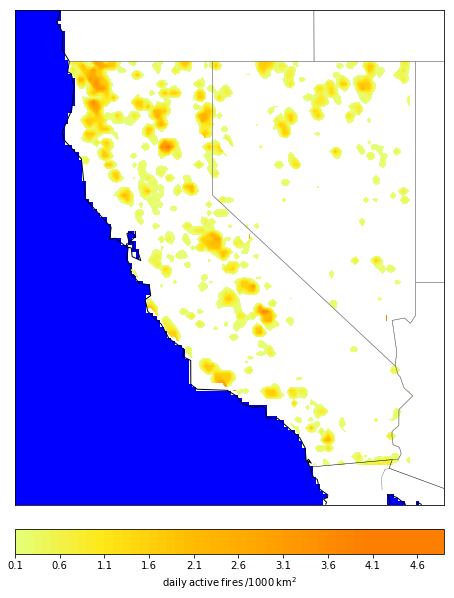

In [124]:
# TODO: make this a movie
# plot data for a single month (create contour maps)
# load data
# select month
MM = "08"
outf = 'FIRE-'+MM+'.csv'
MM_df = pd.read_csv(os.path.join('.','data',outdir,outf))

lon_mag = MM_df['lon'].values
lat_mag = MM_df['lat'].values
mag = MM_df['mag'].values

loncf = np.sort(list(set(lon_mag)))
latcf = np.sort(list(set(lat_mag)))
magcf = np.reshape(mag, (len(latcf),len(loncf)))

# create grid
xx, yy = np.meshgrid(loncf, latcf)
# mask oceans
magcf_new = maskoceans(xx,yy,magcf)

# lat_ts is the latitude of true scale.
# resolution = 'l' means use low resolution coastlines.
lat1 =  43.1
lon1 = -125.8
lat2 =  31.6
lon2 = -113.2

m = Basemap(projection='merc',llcrnrlat=lat2,urcrnrlat=lat1,\
            llcrnrlon=lon1,urcrnrlon=lon2,lat_ts=(lat2+lat1)/2,resolution='l')

plt.figure(figsize=(10,10))
# convert the lat/lon values to x/y projections.
xx, yy = m(*np.meshgrid(loncf, latcf))

cs = m.contourf(xx,yy,magcf_new, levels=np.arange(.1,5,.1), cmap=plt.cm.Wistia,  vmin=0.1, vmax=4 )
cbar = m.colorbar(cs,location='bottom',pad="5%",label=r'${\rm daily\: active\: fires \: /1000\:km^2}$')

m.drawcoastlines()
m.drawstates(color='gray')
m.drawcountries()
m.drawlsmask(land_color='white',ocean_color='b')

plt.show()